In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt, matplotlib.dates as mdates

In [2]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [3]:
!pip install factor_analyzer  
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#%cd drive/MyDrive/Github/master_thesis
%cd drive/MyDrive/GitHub/master-thesis
from clustering.utils import *

/content/drive/MyDrive/GitHub/master-thesis


In [6]:
def cronbach_alpha(df):
    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

# Preprocessing

In [7]:
beh_cols = get_behaviour_cols()
df_fa_input = get_preprocessed_data(impute=True, impute_cols=beh_cols)

In [8]:
# Train Test Split
start_train = '2020-08-01'
end_train = '2020-12-01'
df_fa_input_train = df_fa_input[(df_fa_input.date >= start_train) & (df_fa_input.date < end_train)]
min(df_fa_input_train.date)

Timestamp('2020-08-01 00:00:00')

In [9]:
df_fa_input_train.shape

(34308, 80)

In [10]:
scaler = MinMaxScaler()
fa_input_train = scaler.fit_transform(df_fa_input_train[beh_cols].to_numpy())
fa_input = scaler.fit_transform(df_fa_input[beh_cols].to_numpy())
df_fa_input_scaled = pd.DataFrame(data=fa_input, columns=beh_cols)
fa_input.shape

(118151, 34)

In [11]:
df_fa_input_scaled.shape

(118151, 34)

# Voraussetzungen prüfen
ref: Klaus Backhaus et al. Multivariate analysemethoden. Springer, 2021, pp. 413–488

First, Bartlett’s test (test for sphericity) tests the null hypothesis that the sample originates from
a population in which the variables are uncorrelated. Accordingly, the alternative hypothesis shows
that the variables are correlated. This must be shown for a factor analysis to be appropriate.

In [12]:
# P Value should be smaller 0.05
statistic, p_value = calculate_bartlett_sphericity(fa_input_train)
print(statistic, p_value)

329133.2678091657 0.0


In [13]:
p_value

0.0

Second, the Kaiser-Meyer-Olkin (KMO) criterion, considers the bivariate partial correlations between all variables. This correlation describes the degree of dependence between two variables after excluding the influences of all other variables. The ideal value for a factor analysis is close to 1. In practice, values greater than 0.5 are considered sufficient; values greater than 0.8 are recommended.

In [14]:
#KMO should be greater or equal to 0.5
kmo_per_item, kmo_total = calculate_kmo(fa_input_train)
kmo_total

/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.8955604739885232

In contrast, the Measure of Sampling Adequacy (MSA) as a third method assesses the suitability of individual variables for a factor analysis. This can also be determined with the help of the KMO. If individual variables have MSA values below 0.5, they can be excluded from the factor analysis.

In [15]:
kmo_per_item

array([0.80434484, 0.9044602 , 0.89592167, 0.85512577, 0.92196455,
       0.8821251 , 0.68254153, 0.76065916, 0.9165993 , 0.93866492,
       0.92671007, 0.95246946, 0.93576005, 0.92698805, 0.91086103,
       0.92001054, 0.71717127, 0.83995419, 0.77928216, 0.78564268,
       0.77507203, 0.76748666, 0.72122236, 0.93610924, 0.79512829,
       0.77718579, 0.92962622, 0.87753286, 0.94064022, 0.94120573,
       0.93811493, 0.73990891, 0.93052469, 0.92329604])

In [16]:
(kmo_per_item < 0.5).sum()

0

The fourth and last criterion is the anti-image covariance matrix. The anti-image represents the proportion of the variance that is independent of the other variables. Since factor analysis assumes that common factors are the basis of the variables, the variables are only suitable if they have a high common variance. Accordingly, the anti-image of the variables should be close to zero. As a rule of thumb, the data is suitable if less than 25\% of the non-diagonal elements of the matrix are different from zero.

In [17]:
# calc anti-image covariance matrix
R = np.corrcoef(fa_input_train, rowvar=False)
R_inv = np.linalg.inv(R)
temp = np.diagflat(R_inv.diagonal())
D = np.linalg.inv(temp)

In [18]:
anti_image_covariance_matrix = np.dot(np.dot(D, R_inv), D)

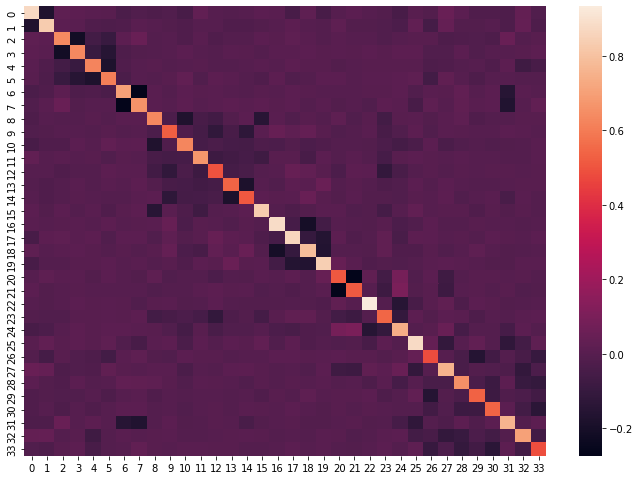

In [19]:
sns.heatmap(anti_image_covariance_matrix)

In [20]:
diff_zero_value = 0.03
num_non_diag_values_differ_from_zero = (anti_image_covariance_matrix > diff_zero_value).sum() + (anti_image_covariance_matrix < -diff_zero_value).sum() - anti_image_covariance_matrix.shape[0]
num_non_diag_values = anti_image_covariance_matrix.shape[0]**2 - - anti_image_covariance_matrix.shape[0]
percentage = num_non_diag_values_differ_from_zero / num_non_diag_values * 100
percentage

18.991596638655462

# Factor Analysis

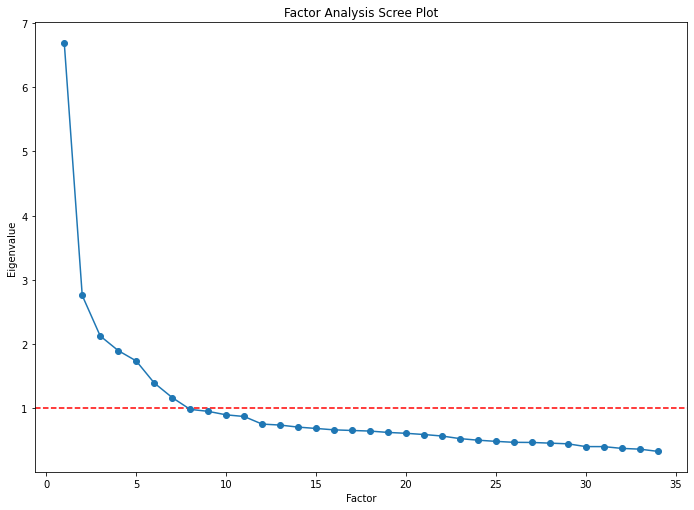

In [21]:
fa = FactorAnalyzer(rotation=None)
fa.fit(fa_input_train)
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
plt.title('Factor Analysis Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='dashed')
plt.plot(range(1,fa_input_train.shape[1]+1),ev, marker='o')
plt.savefig('images/scree_plot_factor_analysis.png')

In [22]:
ev

array([6.69400949, 2.75794238, 2.12742187, 1.89960214, 1.73877994,
       1.39641141, 1.16848795, 0.98419029, 0.95376379, 0.89924314,
       0.87344552, 0.75528034, 0.74001095, 0.70812729, 0.68734724,
       0.66548495, 0.65578516, 0.64651601, 0.62536044, 0.61189927,
       0.59278781, 0.56951274, 0.52897833, 0.50465208, 0.4862528 ,
       0.47128568, 0.46930709, 0.45863737, 0.44798206, 0.40482488,
       0.40447407, 0.37669894, 0.365012  , 0.33048459])

In [23]:
num_factors_one = (ev > 1).sum()
num_factors_avg = (ev > ev.mean()).sum()
explained_variance = ev[:num_factors_one].sum() / ev.sum()
print(f'Es gibt {num_factors_one} Eigenwerte, die größer als eins sind und {num_factors_avg} Eigenwerte, die größer als der Durchschnitt sind. Damit werden {round(explained_variance * 100, 3)} % der Varianz erklärt.')

Es gibt 7 Eigenwerte, die größer als eins sind und 7 Eigenwerte, die größer als der Durchschnitt sind. Damit werden 52.302 % der Varianz erklärt.


In [24]:
n_factor = 6
fa = FactorAnalyzer(n_factor, rotation='varimax')
fa.fit(fa_input_train)
loads = fa.loadings_

# Evaluate Factors

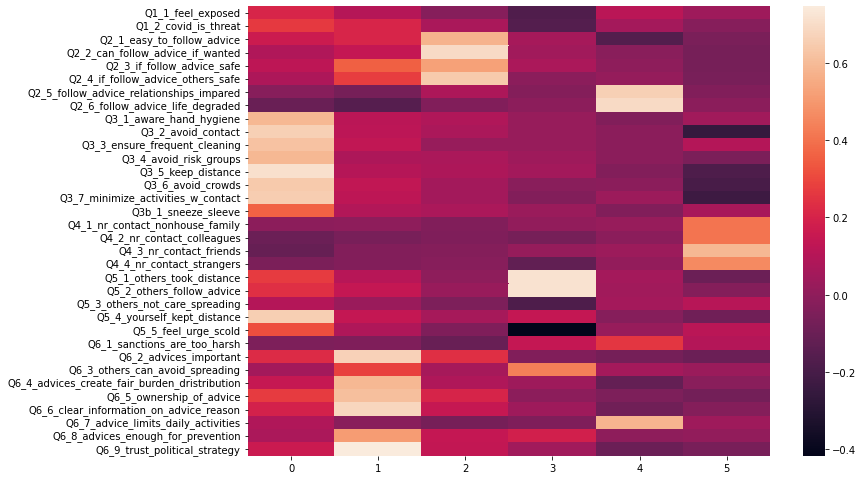

In [25]:
heatmap_data = pd.DataFrame(loads.T, columns=beh_cols).T
heatmap_loadings = sns.heatmap(heatmap_data)
fig = heatmap_loadings.get_figure()
fig.savefig("images/heatmap_factor_loadings.png")

In [26]:
heatmap_data

,0,1,2,3,4,5
Q1_1_feel_exposed,0.206017,0.104760,-0.022877,-0.175559,0.118991,0.038633
Q1_2_covid_is_threat,0.266584,0.206088,0.073316,-0.160231,0.059502,-0.022169
Q2_1_easy_to_follow_advice,0.169304,0.207423,0.578363,0.061835,-0.163185,-0.056114
Q2_2_can_follow_advice_if_wanted,0.089016,0.145339,0.694811,0.048470,-0.013139,-0.062411
Q2_3_if_follow_advice_safe,0.125464,0.359099,0.528030,0.077124,-0.000467,-0.063677
Q2_4_if_follow_advice_others_safe,0.082568,0.274461,0.643175,-0.009169,0.015386,-0.059804
Q2_5_follow_advice_relationships_impared,-0.018350,-0.065175,0.079880,-0.027407,0.663760,-0.038410
Q2_6_follow_advice_life_degraded,-0.101973,-0.153569,-0.035530,-0.007288,0.695676,-0.010909
Q3_1_aware_hand_hygiene,0.587896,0.117668,0.090901,0.020923,-0.037028,0.047392
Q3_2_avoid_contact,0.663394,0.122951,0.074640,0.021902,-0.010225,-0.250791


In [27]:
dict_fa = {}
for i in np.arange(n_factor):
  col_names = heatmap_data[heatmap_data[i].abs() >= 0.5][i].index.tolist()
  df_factor = df_fa_input_scaled[col_names]
  factor_alpha = cronbach_alpha(df_factor)
  temp_dict = {'Factor_Names': col_names, 'Data': df_factor, 'Cronbach_Alpha': factor_alpha}
  print(f'Factor {i} with Columns {col_names} has a Cronbachs Alpha of {factor_alpha}')
  dict_fa.update({i: temp_dict})

Factor 0 with Columns ['Q3_1_aware_hand_hygiene', 'Q3_2_avoid_contact', 'Q3_3_ensure_frequent_cleaning', 'Q3_4_avoid_risk_groups', 'Q3_5_keep_distance', 'Q3_6_avoid_crowds', 'Q3_7_minimize_activities_w_contact', 'Q5_4_yourself_kept_distance'] has a Cronbachs Alpha of 0.8805374855633801
Factor 1 with Columns ['Q6_2_advices_important', 'Q6_4_advices_create_fair_burden_dristribution', 'Q6_5_ownership_of_advice', 'Q6_6_clear_information_on_advice_reason', 'Q6_8_advices_enough_for_prevention', 'Q6_9_trust_political_strategy'] has a Cronbachs Alpha of 0.8474830148581035
Factor 2 with Columns ['Q2_1_easy_to_follow_advice', 'Q2_2_can_follow_advice_if_wanted', 'Q2_3_if_follow_advice_safe', 'Q2_4_if_follow_advice_others_safe'] has a Cronbachs Alpha of 0.7825797188291961
Factor 3 with Columns ['Q5_1_others_took_distance', 'Q5_2_others_follow_advice'] has a Cronbachs Alpha of 0.8060483682828261
Factor 4 with Columns ['Q2_5_follow_advice_relationships_impared', 'Q2_6_follow_advice_life_degraded', '

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [28]:
col_names = ['Q1_1_feel_exposed', 'Q1_2_covid_is_threat', 'Q6_1_sanctions_are_too_harsh', 'Q6_3_others_can_avoid_spreading']
df_fa_input_scaled[col_names].describe()

,Q1_1_feel_exposed,Q1_2_covid_is_threat,Q6_1_sanctions_are_too_harsh,Q6_3_others_can_avoid_spreading
count,118151.000000,118151.000000,118151.000000,118151.000000
mean,0.353053,0.632027,0.374537,0.586733
std,0.300019,0.295284,0.299371,0.259858
min,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.500000,0.000000,0.500000
50%,0.333333,0.666667,0.374537,0.666667
75%,0.500000,1.000000,0.500000,0.833333
max,1.000000,1.000000,1.000000,1.000000


In [29]:
df_fa_input_scaled['Q6_1_sanctions_are_too_harsh'] = df_fa_input_scaled['Q6_1_sanctions_are_too_harsh'] * (-1) + 1
df_fa_input_scaled['Q6_3_others_can_avoid_spreading'] = df_fa_input_scaled['Q6_3_others_can_avoid_spreading'] * (-1) + 1
df_fa_input_scaled[col_names].describe()

,Q1_1_feel_exposed,Q1_2_covid_is_threat,Q6_1_sanctions_are_too_harsh,Q6_3_others_can_avoid_spreading
count,118151.000000,118151.000000,1.181510e+05,1.181510e+05
mean,0.353053,0.632027,6.254629e-01,4.132665e-01
std,0.300019,0.295284,2.993712e-01,2.598578e-01
min,0.000000,0.000000,1.110223e-16,1.110223e-16
25%,0.166667,0.500000,5.000000e-01,1.666667e-01
50%,0.333333,0.666667,6.254629e-01,3.333333e-01
75%,0.500000,1.000000,1.000000e+00,5.000000e-01
max,1.000000,1.000000,1.000000e+00,1.000000e+00


In [30]:
cronbach_alpha(df_fa_input_scaled[['Q1_1_feel_exposed', 'Q1_2_covid_is_threat', 'Q6_1_sanctions_are_too_harsh', 'Q6_3_others_can_avoid_spreading']])

0.3320687495603146

# Create new factors

In [31]:
dict_combination = get_dict_combination()
factor_cols = get_factor_cols()
factor_cols

['F0_cautious_behaviour',
 'F1_perception_advice',
 'F2_applicability_usefullness_advice',
 'F3_behaviour_others',
 'F4_consequence_advice',
 'F5_no_contacts',
 'F6_perceived_threat']

## Regression

In [32]:
new_variables = fa.transform(fa_input)
df_fa_regression = pd.DataFrame(new_variables, columns=factor_cols) 

ValueError: ignored

In [ ]:
df_fa_regression.dropna().info()

## Mean based

In [33]:
df_fa_mean = pd.DataFrame()
#for key in dict_combination:
for key in dict_combination:
  temp_cols = dict_combination[key]
  df_fa_mean[key] = df_fa_input_scaled[temp_cols].mean(axis=1)

In [34]:
df_fa_mean.describe()

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice,F5_no_contacts,F6_perceived_threat
count,118151.000000,118151.000000,118151.000000,118151.000000,118151.000000,118151.000000,118151.000000
mean,0.773248,0.702485,0.787456,0.586427,0.497622,0.175038,0.492540
std,0.191440,0.206350,0.213616,0.236641,0.257021,0.189043,0.237696
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.666667,0.583333,0.708333,0.416667,0.333333,0.031250,0.333333
50%,0.812500,0.722979,0.833333,0.583333,0.500000,0.112500,0.500000
75%,0.916667,0.861111,0.958333,0.750000,0.666667,0.250000,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
df_fa_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118151 entries, 0 to 118150
Data columns (total 7 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   F0_cautious_behaviour                118151 non-null  float64
 1   F1_perception_advice                 118151 non-null  float64
 2   F2_applicability_usefullness_advice  118151 non-null  float64
 3   F3_behaviour_others                  118151 non-null  float64
 4   F4_consequence_advice                118151 non-null  float64
 5   F5_no_contacts                       118151 non-null  float64
 6   F6_perceived_threat                  118151 non-null  float64
dtypes: float64(7)
memory usage: 6.3 MB


In [36]:
df_fa_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118151 entries, 0 to 118150
Data columns (total 80 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   gender                                         118151 non-null  int64         
 1   postnr                                         118151 non-null  int64         
 2   region                                         118151 non-null  object        
 3   Q1_1_feel_exposed                              118151 non-null  float64       
 4   Q1_2_covid_is_threat                           118151 non-null  float64       
 5   Q2_1_easy_to_follow_advice                     118151 non-null  float64       
 6   Q2_2_can_follow_advice_if_wanted               118151 non-null  float64       
 7   Q2_3_if_follow_advice_safe                     118151 non-null  float64       
 8   Q2_4_if_follow_advice_others_safe           

#Combine with original data

In [37]:
subset_drop = factor_cols + ['date']
df_fa_write = pd.concat([df_fa_mean, df_fa_input], axis=1)
df_fa_write.dropna(subset=subset_drop, inplace=True)
df_fa_write_save = df_fa_write.copy()
df_fa_write[subset_drop].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118151 entries, 0 to 118150
Data columns (total 8 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   F0_cautious_behaviour                118151 non-null  float64       
 1   F1_perception_advice                 118151 non-null  float64       
 2   F2_applicability_usefullness_advice  118151 non-null  float64       
 3   F3_behaviour_others                  118151 non-null  float64       
 4   F4_consequence_advice                118151 non-null  float64       
 5   F5_no_contacts                       118151 non-null  float64       
 6   F6_perceived_threat                  118151 non-null  float64       
 7   date                                 118151 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 8.1 MB


# Plot Factors

In [ ]:
df_fa_write = df_fa_write[(df_fa_write.date >= '2020-08-01') & (df_fa_write.date < '2021-02-01')]

In [ ]:
start = '2020-12-01'
end = '2020-12-14'
df_plot = df_fa_write.copy()
df_plot.date = pd.to_datetime(df_plot.date)
in_range = (df_plot.date > start) & (df_plot.date < end)
df_plot = df_plot[in_range]
df_plot = df_plot[factor_cols]
g = sns.PairGrid(data=df_plot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

In [ ]:
import plotly.express as px
df_lineplot = df_fa_write[subset_drop].groupby('date').mean().reset_index()
df_lineplot[factor_cols] = df_lineplot[factor_cols].rolling(3).mean()
px.line(df_lineplot, x='date', y=factor_cols)

In [ ]:
# convert to long (tidy) form
df_lineplot_long = df_lineplot.melt('date', var_name='factor', value_name='values')
df_lineplot_long = df_lineplot_long[df_lineplot_long['values'].notna()].reset_index(drop=True)
df_lineplot_long.date = pd.to_datetime(df_lineplot_long.date, format='%Y-%m-%d')
df_lineplot_long.head()

In [ ]:
df_lineplot_long.info()

In [ ]:
fig, ax = plt.subplots(figsize=(24, 10))
sns.lineplot(x="date", y="values", hue='factor', data=df_lineplot_long, ax=ax)
plt.title('Factor values over time')
ax.legend(loc='best', fontsize='large')
plt.show()

In [ ]:
df_fa_write[subset_drop]

In [ ]:
cols = ['F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'date']
df_lineplot_sd = df_fa_write[cols].melt('date', var_name='factor', value_name='values')
df_lineplot_sd = df_lineplot_sd[df_lineplot_sd['values'].notna()].reset_index(drop=True)
df_lineplot_sd.date = pd.to_datetime(df_lineplot_sd.date, format='%Y-%m-%d')

In [ ]:
sns.lineplot(x="date", y="values", hue='factor', ci='sd', data=df_lineplot_sd)

In [ ]:
for col in factor_cols:
  fig, ax = plt.subplots(figsize=(10, 10))
  sns.lineplot(x="date", y=col, ci='sd', data=df_fa_write[subset_drop], ax=ax)
  ax.set_ylim([0, 1])
  fig.show()

# Write Data

In [39]:
df_fa_write_save.to_csv('data/preprocessing/dim_reduction/220607_fa_data_7_factor.csv', index=False)

In [40]:
df_fa_write_save

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice,F5_no_contacts,F6_perceived_threat,gender,postnr,region,...,Q16_Other,Q16_Unsure_of_party_choice,Q16_Venstre,Vaccination_Status,Willingness_Vaccination,Q4_1_nr_contact_nonhouse_family,Q4_2_nr_contact_colleagues,Q4_3_nr_contact_friends,Q4_4_nr_contact_strangers,Q7_last_week_symptom
0,1.000000,0.819699,0.916667,0.250000,0.555556,0.07500,0.666667,1,4654,Zealand,...,0,0,0,NaN,NaN,0,0,2,2,0
1,0.895833,0.750000,1.000000,0.750000,0.333333,0.15625,0.666667,1,7451,Central,...,0,0,0,1.0,1.0,5,0,0,0,0
2,0.875000,0.666667,0.291667,0.416667,0.611111,0.43750,0.833333,0,4700,Zealand,...,1,0,0,NaN,NaN,4,1,4,15,0
3,0.708333,0.083333,0.041667,0.666667,0.111111,0.13750,0.416667,0,4000,Zealand,...,0,1,0,NaN,NaN,4,0,0,1,0
4,1.000000,0.972222,0.750000,0.833333,0.611111,0.00000,0.500000,0,8543,Central,...,0,0,0,NaN,NaN,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118146,0.854167,0.611111,0.291667,0.586427,0.611111,0.00000,0.416667,1,8220,Central,...,0,0,0,NaN,NaN,0,0,0,0,1
118147,0.895833,0.833333,0.959723,0.666667,0.277778,0.65000,0.500000,1,7400,Central,...,0,0,0,2.0,1.0,8,6,5,10,0
118148,0.520833,0.555556,0.708333,0.583333,0.500000,0.11250,0.250000,1,2400,Capital,...,0,0,0,NaN,NaN,0,0,3,3,0
118149,0.729167,0.722222,0.333333,0.666667,0.388889,0.07500,0.500000,1,5700,Southern,...,0,0,0,2.0,1.0,0,0,3,0,0
